In [32]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
trades_600519 = glob.glob('/Users/kuen/Desktop/MICROSTRUTURE/SH600519/trade_SH_600519*.csv')
quotes_600519 = glob.glob('/Users/kuen/Desktop/MICROSTRUTURE/SH600519/quote_SH_600519*.csv')
trades_601398 = glob.glob('/Users/kuen/Desktop/MICROSTRUTURE/SH601398/trade_SH_601398*.csv')
quotes_601398 = glob.glob('/Users/kuen/Desktop/MICROSTRUTURE/SH601398/quote_SH_601398*.csv')
trade0519 = pd.concat([pd.read_csv(file) for file in trades_600519], ignore_index=True)
quote0519 = pd.concat([pd.read_csv(file) for file in quotes_600519], ignore_index=True)
trade1398 = pd.concat([pd.read_csv(file) for file in trades_601398], ignore_index=True)
quote1398 = pd.concat([pd.read_csv(file) for file in quotes_601398], ignore_index=True)

In [2]:
# Brief view of the datasets
trade0519.head(5)

,Unnamed: 0,date,id_trade,time,sign,BS,price,ntrade
0,1,20130318,0,92500000,NaN,B,176.9,200
1,2,20130318,1,92500000,NaN,B,176.9,600
2,3,20130318,2,92500000,NaN,B,176.9,600
3,4,20130318,3,92500000,NaN,B,176.9,1000
4,5,20130318,4,92500000,NaN,B,176.9,4800


Question 2:
About the Question 2, I would like to use the expecatation attribute of their distribution to calibrate the parameter, but firstly I need to check whether the data is following their distribution. 
If so, I can calibrate the parameter based on the distribution attribute.

In [2]:
# QUESTION 2
# Preparation 
# Data Cleaning: Fill the missing sign
trade0519['sign'] = [1 if trade0519['BS'][i] == 'B' else -1 for i in range(len(trade0519['BS']))]

   sign      prob
0    -1  0.508718
1     1  0.491282
p = [0.49128232]


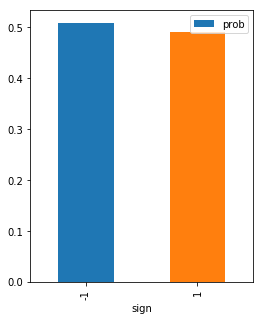

In [4]:
# Parameters Calibration
# P: Sign follows Bernoulli Process, E(Sign) = 1 * p + (-1) * (1 - p) = 2p - 1
sign = trade0519['sign'].value_counts()
sign = pd.DataFrame({'sign':sign.index, 'prob': sign/trade0519['sign'].size})
sign.reset_index(drop=True, inplace=True)
sign_graph = sign.plot.bar(x='sign',y='prob',figsize=(4,5))
sign_graph.legend()
print(sign)
p = sign[sign['sign']==1]['prob'].values
print('p =', p)

About the Bernoulli distribution, the p parameter is obvious, E(X) = 2p - 1, I get p = 0.49.

beta = 0.999999999979196


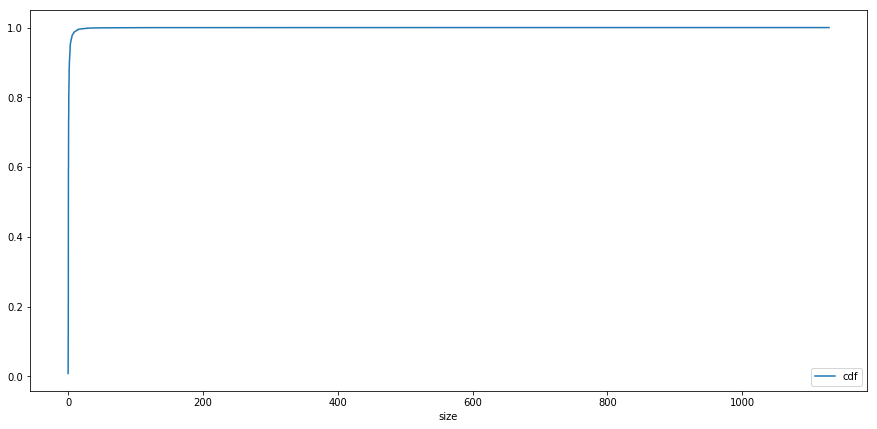

In [5]:
# Beta: Size follows Exponential distribution, E(Size) = beta
# Normalize Vi
trade0519['V_normalized'] = (trade0519['ntrade'] / trade0519['ntrade'].mean())
size = trade0519['V_normalized'].value_counts()/trade0519['V_normalized'].size
size = pd.DataFrame({'size': size.index, 'prob':size})
size.reset_index(drop=True,inplace=True)
size.sort_values('size',inplace=True)
size['cdf'] = size['prob'].cumsum()
size.plot(x='size', y='cdf', figsize=(15,7))
beta = 1/trade0519['V_normalized'].mean()
print('beta =', beta)

As shown in above, the cumulative distribution of data follows the Exponential distribution. 
So I can calculate the beta based on beta = 1/E(X), get beta = 0.999. approxiamately to 1.

lambda_tao = 235.41086040168608
lambda = 47.082172080337216 (min-1)


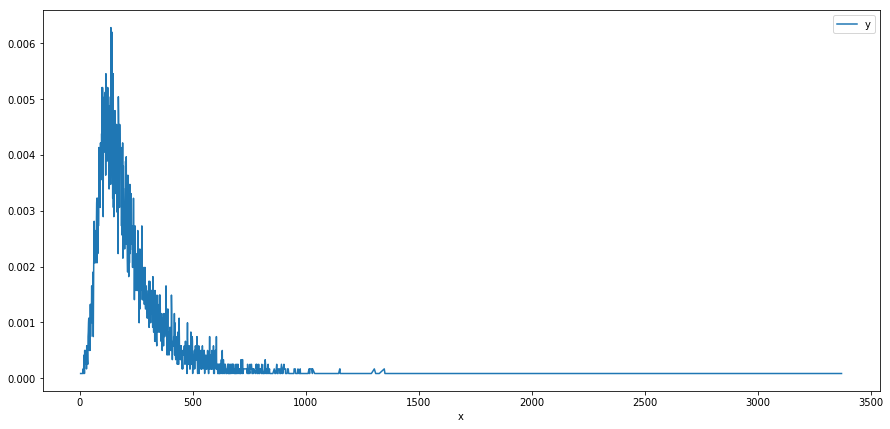

In [3]:
# Lambda
# grouping by time interval tao = 5 mins
# Data cleaning for ['time'], for further usage of groupby
trade0519['time'] = trade0519['time'].astype(str) 
trade0519['time'] = trade0519['time'].str[:-5]
trade0519['time'] = pd.to_numeric(trade0519['time'])
group_N = trade0519.groupby(['date',pd.cut(trade0519['time'], np.arange(925, 1500+5, 5), right=False, include_lowest=True)]).count()
group_N = group_N.dropna()
group_N = group_N.reindex(columns=['ntrade'])
numoftrades = group_N['ntrade'].value_counts()
numoftrades = numoftrades/numoftrades.sum()
numoftrades = pd.DataFrame({'x':numoftrades.index, 'y':numoftrades})
numoftrades.reset_index(drop=True, inplace=True)
numoftrades.sort_values('x',inplace=True)
numoftrades.plot(x='x',y='y',figsize=(15,7))
lambda_tao = group_N['ntrade'].mean()
print('lambda_tao =', lambda_tao)
lambda_ = lambda_tao / 5
print('lambda =', lambda_, '(min-1)')

In [ ]:
As is shown above, the pdf of data follows the poisson distribution, 
so we can calculate the lambda_tao based on E(X). 
Then, I divide the lambda_tao by tao to get the lambda of unit of min-1, 
lambda is 47.09(min-1) or 0.785 (s-1).

In [7]:
# Rho: rho is the correlation of Sign
rho = trade0519['sign'].autocorr()
print('rho =', rho)

rho = 0.5619542356882613


In [ ]:
Because rho^(i-j) = Cov(Si,Sj), I take (i-j) = 1 take get the rho. 
Rho became Cov(Si, Si+1), i.e the auto-correlation of time series sign, 
so I use the pd.Series.autocorr() method to get the rho estimate. Rho = 0.562.

In [ ]:
Question 3:
About the Question 3, I use the trade data as the base and 
use'date+time+price' as an identifiersuse match the quote data. 
It would inevitably loss some data, 
since the two kinds of data is not excatly matched,but in an accepcatable level.
And then I calculate the midquote both on the formula (askprice*bidvolume + bidprice*askvolume)/(asksize+bidsize).
Finally get the accuracy of the "Lee and Ready Algorithm".
For 600519 is 0.827.
For 601398 is 0.946.

In [33]:
# QUESTION 3
# Reset the oringial dataset
trade0519 = pd.concat([pd.read_csv(file) for file in trades_600519], ignore_index=True)
trade0519['sign'] = [1 if trade0519['BS'][i] == 'B' else -1 for i in range(len(trade0519['BS']))]
trade0519['time'] = trade0519['time'].astype(str) 
trade0519['time'] = trade0519['time'].str[:-4]
# Set identifier of TradeData
trade0519['datetime+price'] = trade0519['date'].astype(str) + trade0519['time'] + trade0519['price'].astype(str)

# Set identifier of QuoteData
quote0519 = pd.concat([pd.read_csv(file) for file in quotes_600519], ignore_index=True)
quote0519['time'] = quote0519['time'].astype(str)
quote0519['time'] = quote0519['time'].str[:-1]
quote0519['datetime+price'] = quote0519['date'].astype(str) + quote0519['time'].astype(str) + quote0519['price'].astype(str)
quote0519 = quote0519.reindex(columns=['datetime+price','AskPrice1','AskVolume1','BidPrice1','BidVolume1'])
quote0519.drop_duplicates(subset='datetime+price', inplace = True)

total0519 = pd.merge(trade0519, quote0519, how ='inner')
total0519['midQuote'] = (total0519['AskPrice1']*total0519['BidVolume1'] + 
                         total0519['BidPrice1']*total0519['AskVolume1'])/ (total0519['AskVolume1'] + total0519['BidVolume1'])
total0519['sign_pred'] = [1 if total0519['price'][i] > total0519['midQuote'][i]
                         else 0 if total0519['price'][i] == total0519['midQuote'][i]
                         else -1 for i in range(len(total0519['price']))]
total0519['Accuracy'] = np.where(total0519['sign']==total0519['sign_pred'], 1, 0)
total0519.head(5)

,Unnamed: 0,date,id_trade,time,sign,BS,price,ntrade,datetime+price,AskPrice1,AskVolume1,BidPrice1,BidVolume1,midQuote,sign_pred,Accuracy
0,1,20130318,0,9250,1,B,176.9,200,201303189250176.9,176.9,6322,176.88,100,176.880311,1,1
1,2,20130318,1,9250,1,B,176.9,600,201303189250176.9,176.9,6322,176.88,100,176.880311,1,1
2,3,20130318,2,9250,1,B,176.9,600,201303189250176.9,176.9,6322,176.88,100,176.880311,1,1
3,4,20130318,3,9250,1,B,176.9,1000,201303189250176.9,176.9,6322,176.88,100,176.880311,1,1
4,5,20130318,4,9250,1,B,176.9,4800,201303189250176.9,176.9,6322,176.88,100,176.880311,1,1


In [34]:
#The Same Calculation Process for 601398

#Reset the oringial dataset
trade1398 = pd.concat([pd.read_csv(file) for file in trades_601398], ignore_index=True)
trade1398['sign'] = [1 if trade1398['BS'][i] == 'B' else -1 for i in range(len(trade1398['BS']))]
trade1398['time'] = trade1398['time'].astype(str) 
trade1398['time'] = trade1398['time'].str[:-4]
# Set identifier of TradeData
trade1398['datetime+price'] = trade1398['date'].astype(str) + trade1398['time'] + trade1398['price'].astype(str)

# Set identifier of QuoteData
quote1398 = pd.concat([pd.read_csv(file) for file in quotes_601398], ignore_index=True)
quote1398['time'] = quote1398['time'].astype(str)
quote1398['time'] = quote1398['time'].str[:-1]
quote1398['datetime+price'] = quote1398['date'].astype(str) + quote1398['time'].astype(str) + quote1398['price'].astype(str)
quote1398 = quote1398.reindex(columns=['datetime+price','AskPrice1','AskVolume1','BidPrice1','BidVolume1'])
quote1398.drop_duplicates(subset='datetime+price', inplace = True)

total1398 = pd.merge(trade1398, quote1398, how ='inner')
total1398['midQuote'] = (total1398['AskPrice1']*total1398['BidVolume1'] + 
                         total1398['BidPrice1']*total1398['AskVolume1'])/ (total1398['AskVolume1'] + total1398['BidVolume1'])
total1398['sign_pred'] = [1 if total1398['price'][i] > total1398['midQuote'][i]
                         else 0 if total1398['price'][i] == total1398['midQuote'][i]
                         else -1 for i in range(len(total1398['price']))]

total1398['Accuracy'] = np.where(total1398['sign']==total1398['sign_pred'], 1, 0)

# Calculate Result
accuracy0519 = total0519['Accuracy'].sum()/ total0519.count()[0]
accuracy1398 = total1398['Accuracy'].sum()/ total1398.count()[0]
print('The Accuracy of Lee and Ready Algorithm in 600519 is:',accuracy0519)
print('The Accuracy of Lee and Ready Algorithm in 601398 is:',accuracy1398)

The Accuracy of Lee and Ready Algorithm in 600519 is: 0.827343428150564
The Accuracy of Lee and Ready Algorithm in 601398 is: 0.9461737848829269


In [ ]:
Question 4:
About the Question 4, I use the dataset of Q3, since I calculate the midquote as the same formula.
Group by time interval with different interval (1 and 5 mins) to 
calculate the sum of IMB.divide the data into two groups: Positive IMB and Negative IMB.
And in the end, use curve_fit function of scipy.optimize to fit the parameter to compare.

In [31]:
# Question 4
# For 600519
print('Stock 600519')
for i in [1,5]:
    print('For Tao =', i, 'min(s):')
    # normalize size
    total0519['V_normalized'] = total0519['ntrade']/ total0519['ntrade'].mean()
    total0519['IMB'] = total0519['sign'] * total0519['V_normalized']

    # calculate Ret
    Ret0519 = total0519.reindex(columns=['date','time','midQuote'])
    Ret0519['time'] = Ret0519['time'].str[:-1]
    Ret0519['time'] = pd.to_numeric(Ret0519['time'])
    Ret0519 = Ret0519.groupby(['date',pd.cut(Ret0519['time'], np.arange(925, 1500+i, i),right=False, include_lowest=True)]
                     ).midQuote.apply(lambda x:(x.tail(1).values[0]-x.head(1).values[0])/x.head(1).values[0])
    Ret0519 = Ret0519.dropna()
    
    IMBnSize0519 = total0519.reindex(columns=['date','time','IMB','V_normalized'])
    IMBnSize0519['time'] = IMBnSize0519['time'].str[:-1]
    IMBnSize0519['time'] = pd.to_numeric(IMBnSize0519['time'])
    IMBnSize0519 = IMBnSize0519.groupby(['date',pd.cut(IMBnSize0519['time'], np.arange(925, 1500+i, i), 
                                               right=False, include_lowest=True)]
                                               ).agg({'IMB': 'sum', 'V_normalized':['size', 'sum']})
    
    IMBnSize0519 = IMBnSize0519.dropna()

    concat0519 = pd.concat([IMBnSize0519, Ret0519],axis=1)
    concat0519.columns = ['IMB','V_size','V_sum','Ret0519']
    concat0519 = concat0519[~concat0519.isin([np.nan, np.inf, -np.inf]).any(1)]
    concat0519['sign_IMB'] = [1 if concat0519['IMB'][i] > 0 else -1 for i in range(len(concat0519['IMB']))]
    vol0519 = concat0519['Ret0519'].std()
    
    positive = concat0519[concat0519['sign_IMB'] == 1]
    beta_positive = 1/(positive['V_sum'].sum()/ positive['V_size'].sum())
    print('Beta_Positive for',i,'min(s):', beta_positive)
    
    def RetModel_Positive(IMB,gamma):
        beta = beta_positive
        vol = vol0519
        return beta*vol*(abs(IMB)**gamma)
    
    from scipy.optimize import curve_fit
    fit_gamma = curve_fit(RetModel_Positive, positive['IMB'], positive['Ret0519'])
    print('Gamma_Positive for',i,'min(s):', fit_gamma[0])
    
    negative = concat0519[concat0519['sign_IMB'] == -1]
    beta_negative = 1/(negative['V_sum'].sum()/ negative['V_size'].sum())
    print('Beta_Negative for',i,'min(s):', beta_negative)
    
    def RetModel_negative(IMB,gamma):
        beta = beta_negative
        vol = vol0519
        return beta*vol*(abs(IMB)**gamma)
    
    from scipy.optimize import curve_fit
    fit_gamma = curve_fit(RetModel_negative, negative['IMB'], negative['Ret0519'])
    print('Gamma_Negative for',i,'min(s):', fit_gamma[0],'\n')

Stock 600519
For Tao = 1 min(s):
Beta_Positive for 1 min(s): 0.9691311569995028
Gamma_Positive for 1 min(s): [-0.06643271]
Beta_Negative for 1 min(s): 1.0489573845148228
Gamma_Negative for 1 min(s): [-0.01503149] 

For Tao = 5 min(s):
Beta_Positive for 5 min(s): 0.9671814719085113
Gamma_Positive for 5 min(s): [-0.08638487]
Beta_Negative for 5 min(s): 1.056750544474975
Gamma_Negative for 5 min(s): [-0.04240920] 



In [29]:
# For 601398
print('Stock 601398')
for i in [1,5]:
    print('For Tao =', i, 'min(s):')
    # normalize size
    total1398['V_normalized'] = total1398['ntrade']/ total1398['ntrade'].mean()
    total1398['IMB'] = total1398['sign'] * total1398['V_normalized']

    # calculate Ret
    Ret1398 = total1398.reindex(columns=['date','time','midQuote'])
    Ret1398['time'] = Ret1398['time'].str[:-1]
    Ret1398['time'] = pd.to_numeric(Ret1398['time'])
    Ret1398 = Ret1398.groupby(['date',pd.cut(Ret1398['time'], np.arange(925, 1500+i, i),right=False, include_lowest=True)]
                     ).midQuote.apply(lambda x:100*(x.tail(1).values[0]-x.head(1).values[0])/x.head(1).values[0])
    Ret1398 = Ret1398.dropna()
    
    IMBnSize1398 = total1398.reindex(columns=['date','time','IMB','V_normalized'])
    IMBnSize1398['time'] = IMBnSize1398['time'].str[:-1]
    IMBnSize1398['time'] = pd.to_numeric(IMBnSize1398['time'])
    IMBnSize1398 = IMBnSize1398.groupby(['date',pd.cut(IMBnSize1398['time'], np.arange(925, 1500+i, i), 
                                               right=False, include_lowest=True)]
                                               ).agg({'IMB': 'sum', 'V_normalized':['size', 'sum']})
    
    IMBnSize1398 = IMBnSize1398.dropna()

    concat1398 = pd.concat([IMBnSize1398, Ret1398],axis=1)
    concat1398.columns = ['IMB','V_size','V_sum','Ret1398']
    concat1398['sign_IMB'] = [1 if concat1398['IMB'][i] > 0 else -1 for i in range(len(concat1398['IMB']))]
    vol1398 = concat1398['Ret1398'].std()
    concat1398 = concat1398[~concat1398.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    positive = concat1398[concat1398['sign_IMB'] == 1]
    beta_positive = 1/(positive['V_sum'].sum()/ positive['V_size'].sum())
    print('Beta_Positive for',i,'min(s):', beta_positive)
    
    def RetModel_Positive(IMB,gamma):
        beta = beta_positive
        vol = vol1398
        return beta*vol*(abs(IMB)**gamma)
    
    from scipy.optimize import curve_fit
    fit_gamma = curve_fit(RetModel_Positive, positive['IMB'], positive['Ret1398'])
    print('Gamma_Positive for',i,'min(s):', fit_gamma[0])

    negative = concat1398[concat1398['sign_IMB'] == -1]
    beta_negative = 1/(negative['V_sum'].sum()/ negative['V_size'].sum())
    print('Beta_Negative for',i,'min(s):', beta_negative)
    
    def RetModel_negative(IMB,gamma):
        beta = beta_negative
        vol = vol1398
        return beta*vol*(abs(IMB)**gamma)
    
    from scipy.optimize import curve_fit
    fit_gamma = curve_fit(RetModel_negative, negative['IMB'], negative['Ret1398'])
    print('Gamma_Negative for',i,'min(s):', fit_gamma[0],'\n')

Stock 601398
For Tao = 1 min(s):
Beta_Positive for 1 min(s): 0.9611842340043053
Gamma_Positive for 1 min(s): [0.03481298]
Beta_Negative for 1 min(s): 1.0354858125746629
Gamma_Negative for 1 min(s): [-0.03924121] 

For Tao = 5 min(s):
Beta_Positive for 5 min(s): 0.9641772245148831
Gamma_Positive for 5 min(s): [0.025937092]
Beta_Negative for 5 min(s): 1.0318807543122237
Gamma_Negative for 5 min(s): [-0.05078973] 



Compare and Comment: For both the stock 600519 and 601398, 
(1) The Beta_Positive and Beta_Negative of different time intervals are very approximate to 1.
(2) With the increase of time interval, the Beta_Negative becomes larger.
(3) The Beta_Negative is obviously larger than the Beta_Positive, when Beta_Negative is larger than 1 and Beta_Positive is smaller than 1.
(4) Most of the Gammas are less than 0 
(5) Gamma_Positive is slight larger than Gamma_Neagative. 